In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import boxcox
import numpy as np
from statsmodels.tsa.stattools import adfuller

In [ ]:
df=pd.read_csv('all_tickets.tsv',sep='\t')
df_2 = pd.read_csv('tree_queue.tsv',sep='\t')
df

,date,queueId,new_t
0,1564535464441,100366,103176935
1,1564535470422,100366,103176934
2,1564535487019,71,103176923
3,1564535588196,4237,103176897
4,1564535594788,4237,103176942
...,...,...,...
993858,1563319947502,3602,102952903
993859,1563320153493,2163,102967874
993860,1563320188741,100104,102951452
993861,1563320375970,100265,102968407


In [ ]:
df_2

,parentQueueId,childrenIds
0,2010,"[2330, 2010]"
1,1571,"[3085, 1571]"
2,100153,"[3546, 100153, 2732, 1162, 100113, 2980, 3810,..."
3,2538,"[3252, 2583, 2538]"
4,100192,"[100193, 100192]"
...,...,...
332,9,"[9, 1511, 1002]"
333,2438,"[2727, 2438]"
334,2321,"[2321, 2927]"
335,2842,"[2846, 2842, 2820, 2843, 2885]"


In [ ]:
df['date'] = pd.to_datetime(df['date'], unit='ms')
df

,date,queueId,new_t
0,2019-07-31 01:11:04.441,100366,103176935
1,2019-07-31 01:11:10.422,100366,103176934
2,2019-07-31 01:11:27.019,71,103176923
3,2019-07-31 01:13:08.196,4237,103176897
4,2019-07-31 01:13:14.788,4237,103176942
...,...,...,...
993858,2019-07-16 23:32:27.502,3602,102952903
993859,2019-07-16 23:35:53.493,2163,102967874
993860,2019-07-16 23:36:28.741,100104,102951452
993861,2019-07-16 23:39:35.970,100265,102968407


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 993863 entries, 0 to 993862
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   date     993863 non-null  datetime64[ns]
 1   queueId  993863 non-null  int64         
 2   new_t    993863 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 22.7 MB


In [ ]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   parentQueueId  337 non-null    int64 
 1   childrenIds    337 non-null    object
dtypes: int64(1), object(1)
memory usage: 5.4+ KB


In [ ]:
df.isnull().sum()

,0
date,0
queueId,0
new_t,0


In [ ]:
df_2.isnull().sum()

,0
parentQueueId,0
childrenIds,0


In [ ]:
df[df['queueId'] == 71]

,date,queueId,new_t
2,2019-07-31 01:11:27.019,71,103176923
861,2019-07-31 04:41:15.000,71,103177858
2133,2019-07-31 06:21:31.914,71,103179357
4016,2019-07-31 07:52:45.863,71,103181073
4287,2019-07-31 08:06:43.065,71,103181423
...,...,...,...
415261,2019-07-10 09:09:36.389,71,102877243
415710,2019-07-10 09:23:35.753,71,102877426
415979,2019-07-10 09:33:25.251,71,102877605
416231,2019-07-10 09:49:14.722,71,102877732


In [ ]:
daily_counts = df["date"].dt.floor("D").value_counts().sort_index()

In [ ]:
daily_counts.index = pd.to_datetime(daily_counts.index)

In [ ]:
daily_counts

,count
date,
2019-07-01,32090
2019-07-02,33665
2019-07-03,33107
2019-07-04,33813
2019-07-05,33359
2019-07-06,25394
2019-07-07,25186
2019-07-08,35900
2019-07-09,34802


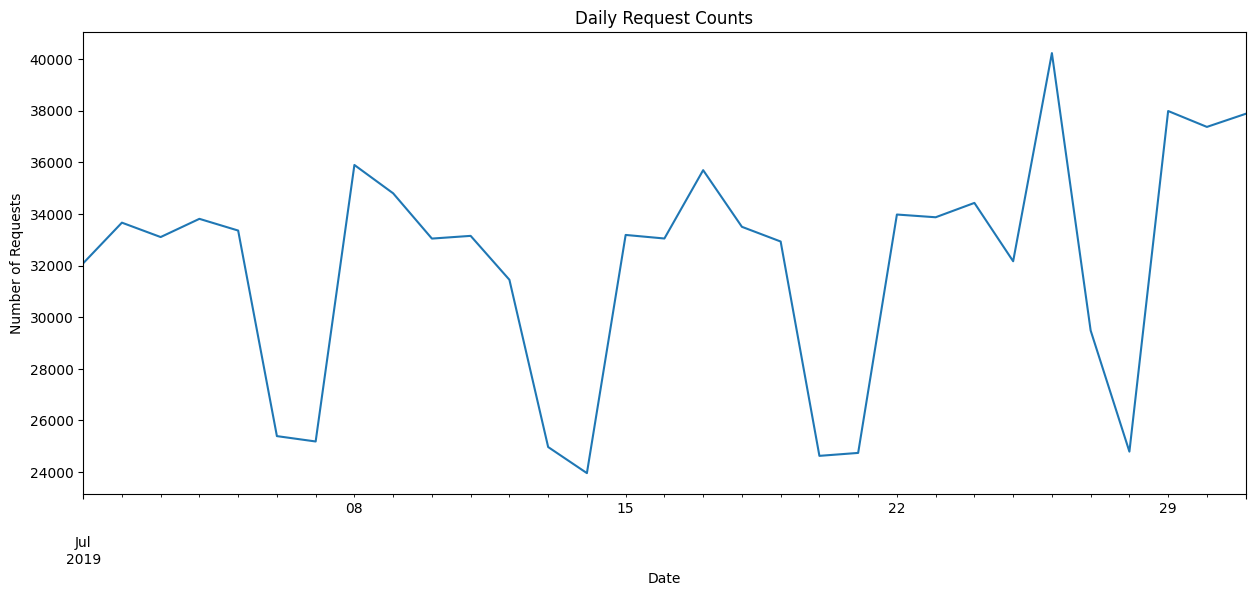

In [ ]:
plt.figure(figsize=(15, 6))
daily_counts.plot()
plt.title("Daily Request Counts")
plt.xlabel("Date")
plt.ylabel("Number of Requests")
plt.show()

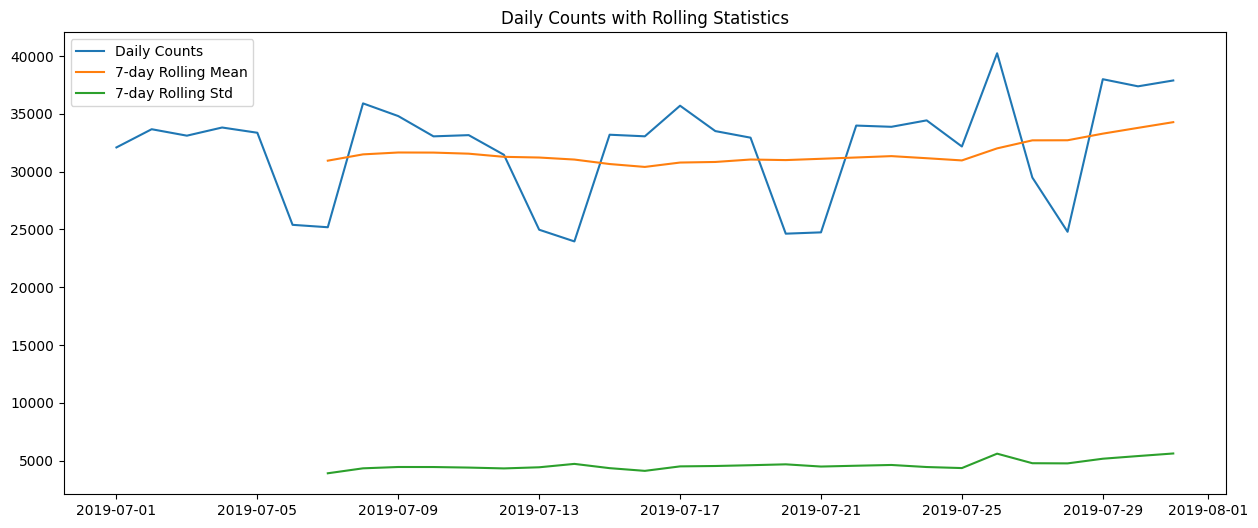

In [ ]:
rolling_mean = daily_counts.rolling(window=7).mean()
rolling_std = daily_counts.rolling(window=7).std()

plt.figure(figsize=(15, 6))
plt.plot(daily_counts, label="Daily Counts")
plt.plot(rolling_mean, label="7-day Rolling Mean")
plt.plot(rolling_std, label="7-day Rolling Std")
plt.legend()
plt.title("Daily Counts with Rolling Statistics")
plt.show()

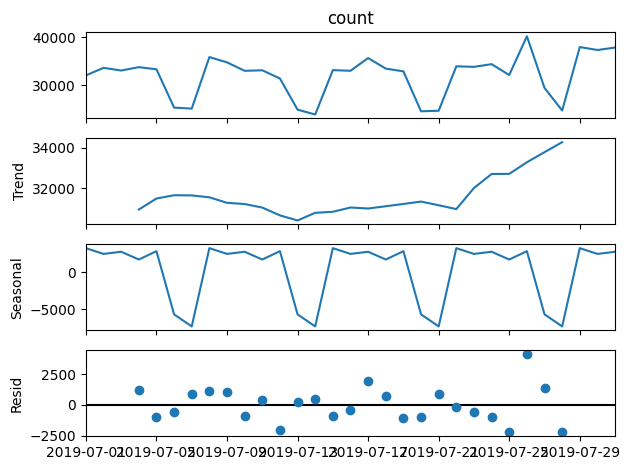

In [ ]:
decomposition = seasonal_decompose(daily_counts, model="additive", period=7)
decomposition.plot()
plt.tight_layout()
plt.show()

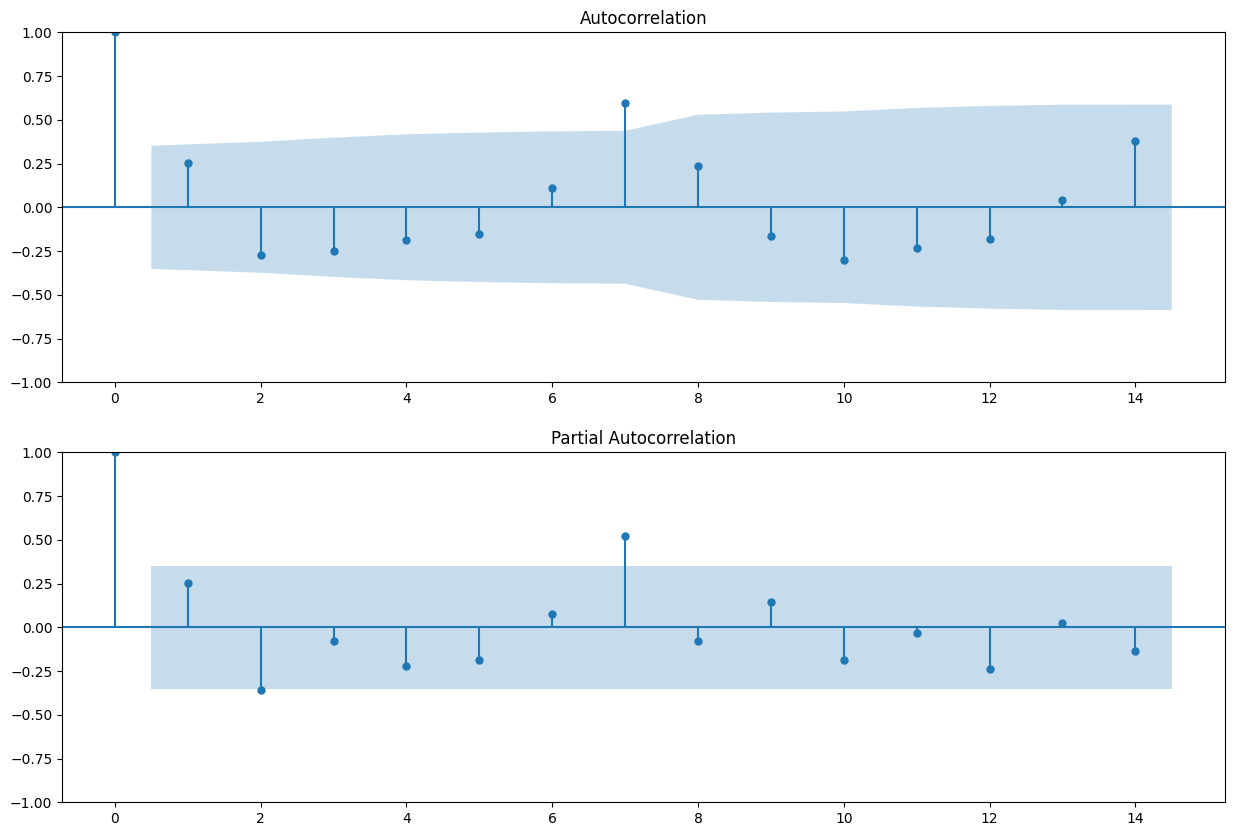

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))
plot_acf(daily_counts, ax=ax1, lags=14)
plot_pacf(daily_counts, ax=ax2, lags=14)
plt.show()

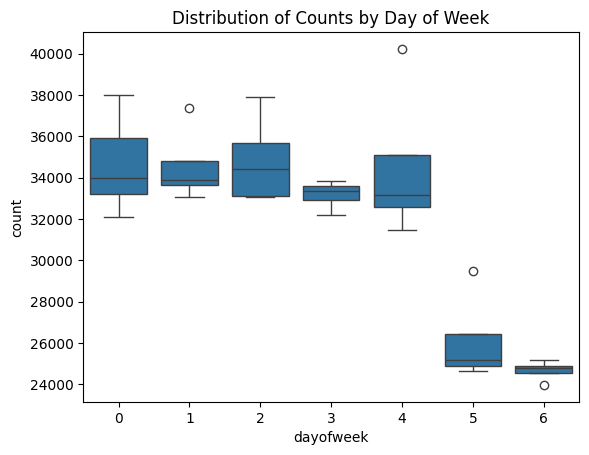

In [ ]:
daily_counts.index = pd.to_datetime(daily_counts.index)
daily_counts_df = pd.DataFrame(
    {"count": daily_counts, "dayofweek": daily_counts.index.dayofweek}
)
sns.boxplot(x="dayofweek", y="count", data=daily_counts_df)
plt.title("Distribution of Counts by Day of Week")
plt.show()

In [ ]:
print(daily_counts.describe())

count       31.000000
mean     32060.096774
std       4487.286896
min      23960.000000
25%      30469.000000
50%      33153.000000
75%      34205.000000
max      40234.000000
Name: count, dtype: float64


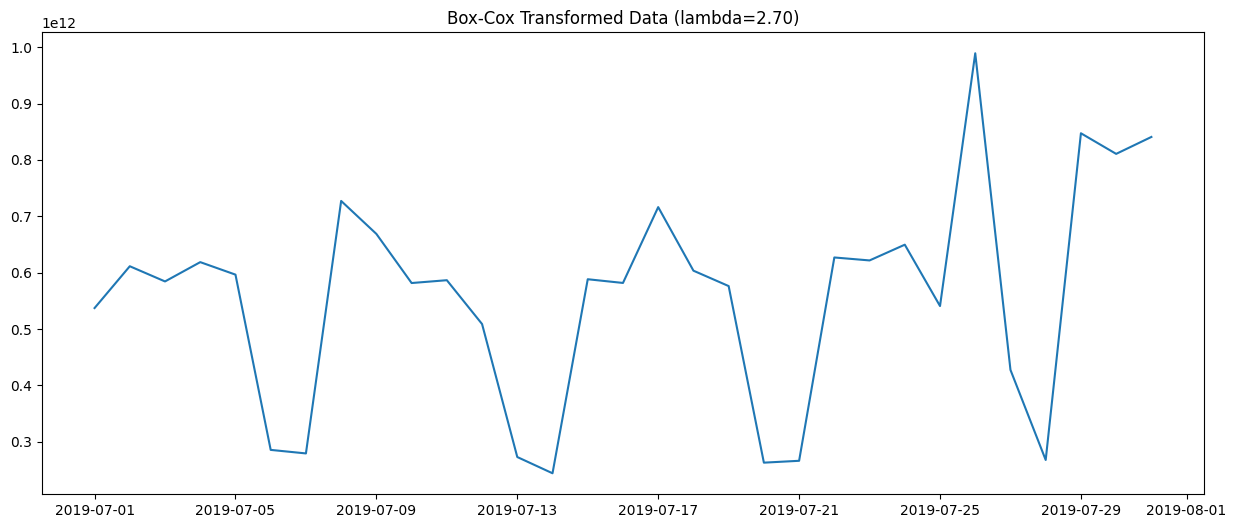

In [ ]:
daily_counts_positive = daily_counts[
    daily_counts > 0
]  # Box-Cox requires positive values
transformed_data, lambda_param = boxcox(daily_counts_positive)

plt.figure(figsize=(15, 6))
plt.plot(daily_counts_positive.index, transformed_data)
plt.title(f"Box-Cox Transformed Data (lambda={lambda_param:.2f})")
plt.show()

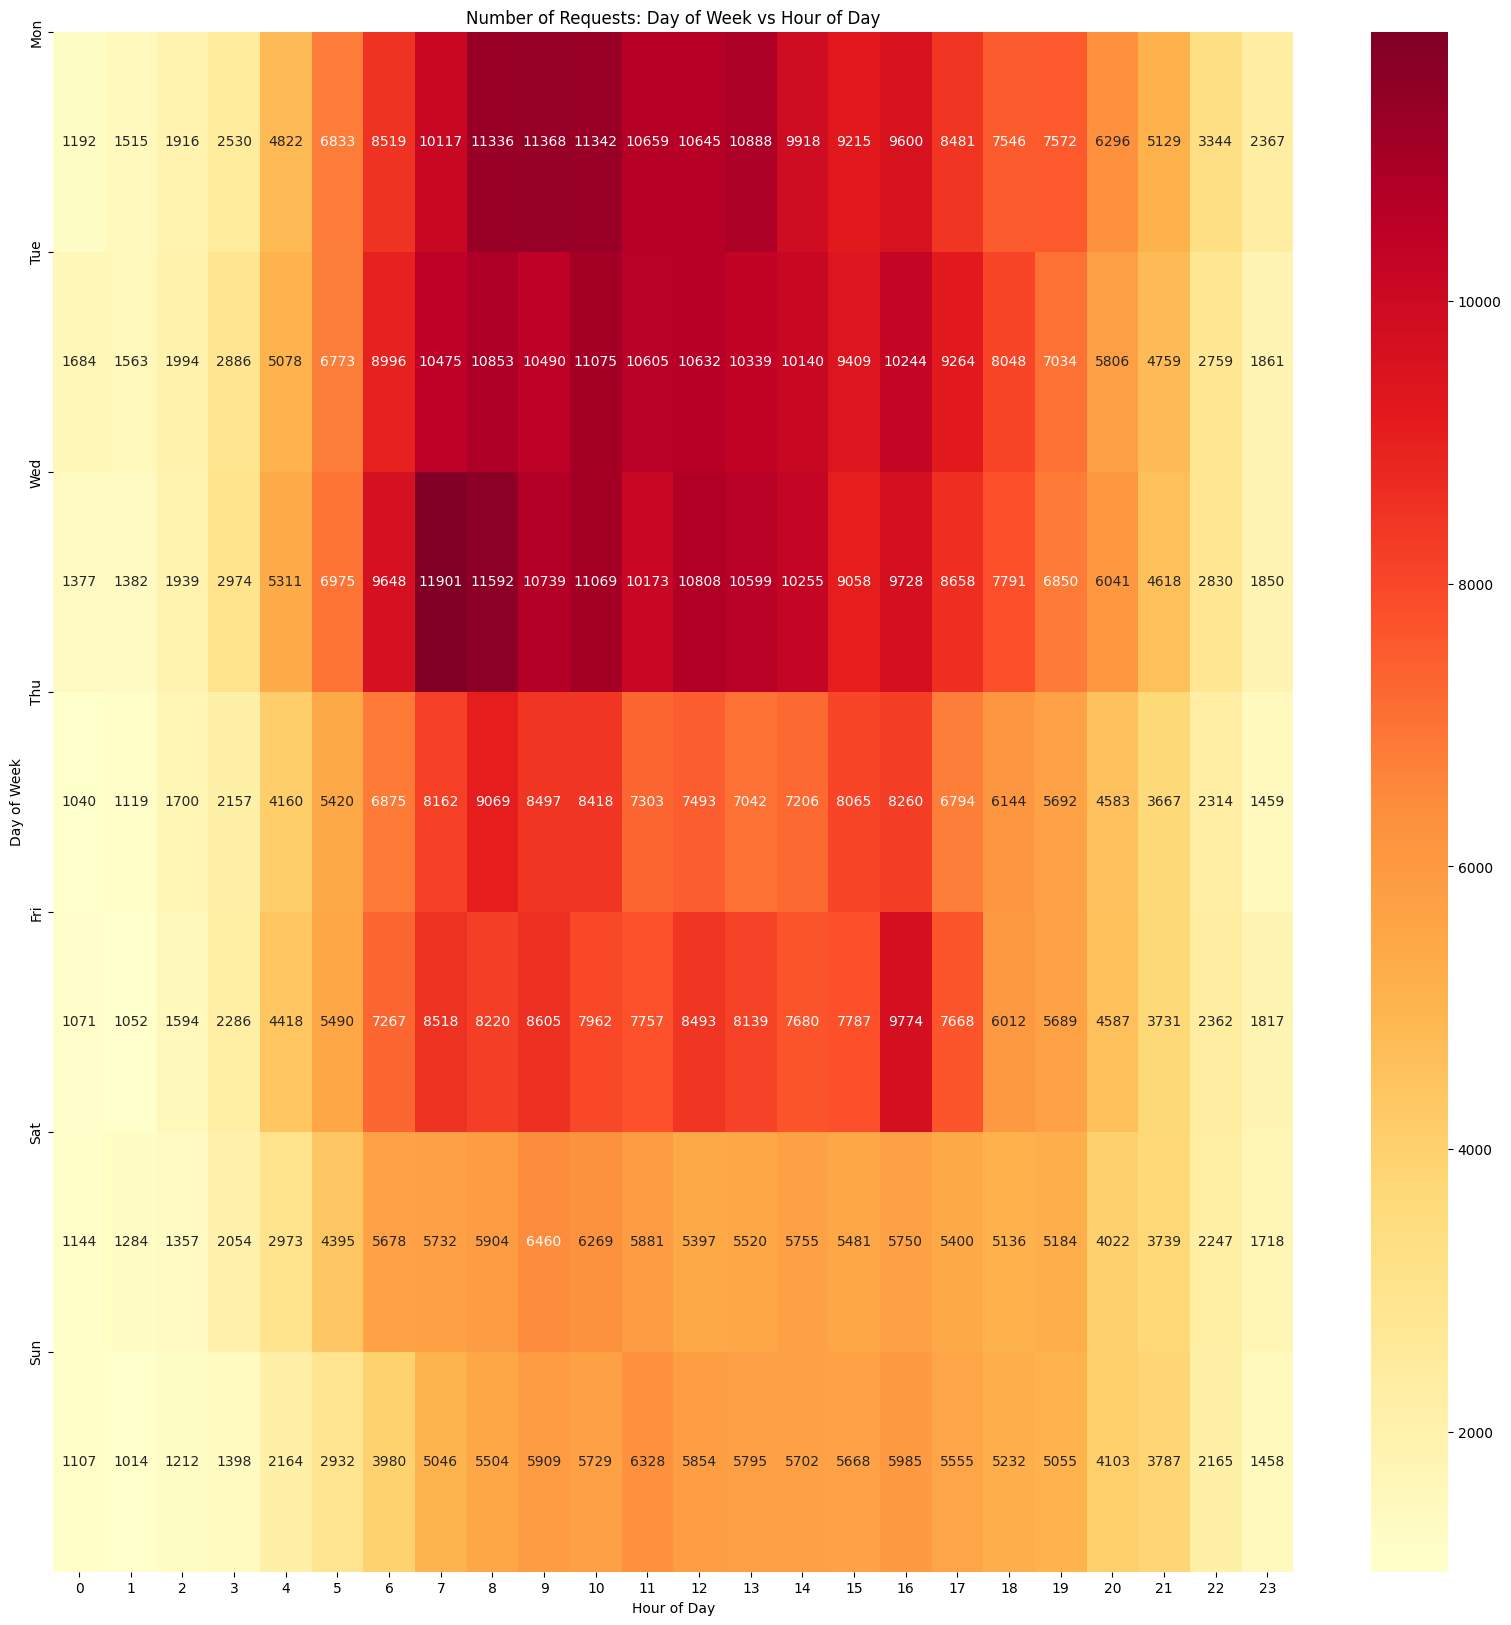

In [ ]:

# Create a heatmap for day of week vs hour of day
df["day_of_week"] = df["date"].dt.dayofweek
heatmap_data = df.groupby(["day_of_week", "hour"]).size().unstack()
plt.figure(figsize=(20, 20))
sns.heatmap(heatmap_data, cmap="YlOrRd", annot=True, fmt="g")
plt.title("Number of Requests: Day of Week vs Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.yticks(range(7), ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.show()

In [ ]:
def evaluate_grouping(df, freq):
    # Group the data
    grouped = df["date"].dt.floor(freq).value_counts().sort_index()

    # Calculate total possible periods
    date_range = pd.date_range(
        start=df["date"].min(), end=df["date"].max(), freq=freq
    )
    total_possible_periods = len(date_range)

    # Calculate statistics
    mean = grouped.mean()
    std = grouped.std()
    cv = std / mean  # Coefficient of variation

    # Calculate percentage of periods with data
    periods_with_data = len(grouped)
    percentage_periods_with_data = (periods_with_data / total_possible_periods) * 100

    # Perform ADF test
    adf_result = adfuller(grouped.dropna())

    # Try seasonal decomposition
    try:
        if freq in ["D", "12H", "6H"]:
            period = 7
        elif freq == "4H":
            period = 42
        elif freq == "2H":
            period = 84
        else:
            period = 168

        decompose = seasonal_decompose(grouped, model="additive", period=period)
        seasonal_strength = 1 - np.var(decompose.resid) / np.var(
            decompose.seasonal + decompose.resid
        )
    except:
        seasonal_strength = np.nan

    return {
        "Frequency": freq,
        "Mean": mean,
        "Std Dev": std,
        "Coefficient of Variation": cv,
        "Percentage Periods with Data": percentage_periods_with_data,
        "ADF Statistic": adf_result[0],
        "ADF p-value": adf_result[1],
        "Seasonal Strength": seasonal_strength,
    }


# Assuming your DataFrame is called df and has a column 'date_req'
# If not, load it first:
# df = pd.read_csv('your_data.csv', parse_dates=['date_req'])

# List of frequencies to test
frequencies = ["D", "12H", "6H", "4H", "2H", "h"]

# Evaluate each frequency
results = []
for freq in frequencies:
    results.append(evaluate_grouping(df, freq))

# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(results_df)

<ipython-input-55-08c94264a4e3>:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  grouped = df["date"].dt.floor(freq).value_counts().sort_index()
<ipython-input-55-08c94264a4e3>:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(
<ipython-input-55-08c94264a4e3>:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  grouped = df["date"].dt.floor(freq).value_counts().sort_index()
<ipython-input-55-08c94264a4e3>:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_range = pd.date_range(
<ipython-input-55-08c94264a4e3>:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  grouped = df["date"].dt.floor(freq).value_counts().sort_index()
<ipython-input-55-08c94264a4e3>:6: FutureWarning: 'H' is deprecated and will 

  Frequency          Mean      Std Dev  Coefficient of Variation  \
0         D  32060.096774  4487.286896                  0.139965   
1       12H  16030.048387  2539.423301                  0.158416   
2        6H   8015.024194  3619.921525                  0.451642   
3        4H   5343.349462  2526.714335                  0.472871   
4        2H   2671.674731  1340.891056                  0.501892   
5         h   1335.837366   683.389468                  0.511581   

   Percentage Periods with Data  ADF Statistic  ADF p-value  Seasonal Strength  
0                         100.0       1.246634     0.996293           0.901652  
1                         100.0      -1.518183     0.524498           0.310534  
2                         100.0      -3.438116     0.009726           0.013288  
3                         100.0      -3.189328     0.020611           0.958892  
4                         100.0      -4.000085     0.001410           0.942300  
5                         100.0      

In [ ]:
queue_stats = df.groupby('queueId')['new_t'].agg(['mean', 'std', 'min', 'max', 'count'])
print(queue_stats)


                 mean           std        min        max  count
queueId                                                         
1        1.028853e+08  2.024036e+06   29781302  103193386   1757
3        1.029632e+08  3.305109e+05  100464022  103187590    134
4        2.885689e+07  1.262862e+06   27963912   29749868      2
7        1.029793e+08  1.453979e+05  102133706  103193587   2490
9        1.030142e+08  5.982336e+04  102971923  103056526      2
...               ...           ...        ...        ...    ...
100421   1.029990e+08  6.834893e+04  102904584  103164427     12
100427   1.031911e+08  1.191914e+03  103189782  103194308     54
100429   1.031920e+08  1.453930e+03  103189457  103194424    546
100430   1.031919e+08  1.185517e+03  103189630  103194233    122
100440   1.031308e+08  3.090764e+03  103128611  103132982      2

[570 rows x 5 columns]


<Axes: title={'center': 'Количество новых тикетов по дням'}, xlabel='date'>

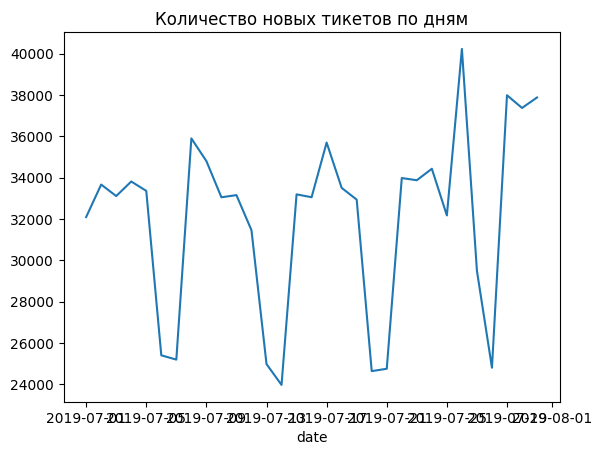

In [ ]:
df['date'] = df['date'].dt.date  # Оставляем только дату без времени

# Группировка по дням и подсчет количества новых тикетов
tickets_per_day = df.groupby('date')['new_t'].count()
# Визуализация
tickets_per_day.plot(title='Количество новых тикетов по дням')


In [ ]:
tickets_per_queue = df.groupby('queueId')['new_t'].count().sort_values(ascending=False)
print(tickets_per_queue)

#tickets_per_queue.plot(kind='bar', title='Количество тикетов по очередям')


queueId
4212      138604
4237      137975
4462       78150
4472       53902
4457       29814
           ...  
1907           1
2356           1
2348           1
2007           1
100116         1
Name: new_t, Length: 570, dtype: int64


<Axes: title={'center': 'Количество тикетов по часам'}, xlabel='hour'>

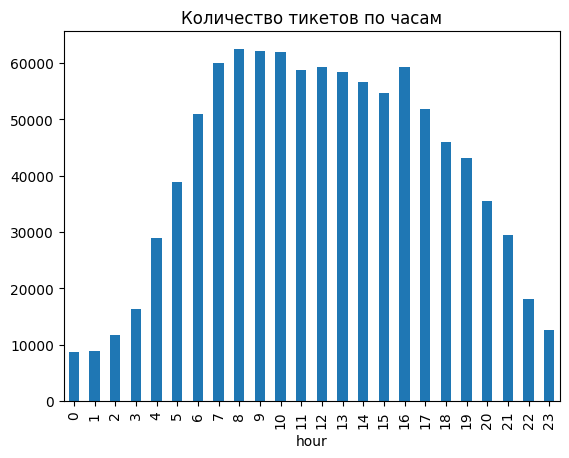

In [ ]:
df['hour'] = df['date'].dt.hour

tickets_per_hour = df.groupby('hour')['new_t'].count()
tickets_per_hour.plot(kind='bar', title='Количество тикетов по часам')


In [ ]:
max_day = tickets_per_day.idxmax()
max_tickets = tickets_per_day.max()
print(f"Максимум тикетов ({max_tickets}) был создан {max_day}")

max_hour = tickets_per_hour.idxmax()
max_hour_tickets = tickets_per_hour.max()
print(f"Наибольшая активность по часам: {max_hour} час — {max_hour_tickets} тикетов")


Максимум тикетов (40234) был создан 2019-07-26
Наибольшая активность по часам: 8 час — 62478 тикетов


In [ ]:
missing_days = pd.date_range(start=df['date'].min(), end=df['date'].max()).difference(df['date'])
print(f"Пропущенные даты: {missing_days}")


Пропущенные даты: DatetimeIndex(['2019-07-02 00:00:49.870000', '2019-07-03 00:00:49.870000',
               '2019-07-04 00:00:49.870000', '2019-07-05 00:00:49.870000',
               '2019-07-06 00:00:49.870000', '2019-07-07 00:00:49.870000',
               '2019-07-08 00:00:49.870000', '2019-07-09 00:00:49.870000',
               '2019-07-10 00:00:49.870000', '2019-07-11 00:00:49.870000',
               '2019-07-12 00:00:49.870000', '2019-07-13 00:00:49.870000',
               '2019-07-14 00:00:49.870000', '2019-07-15 00:00:49.870000',
               '2019-07-16 00:00:49.870000', '2019-07-17 00:00:49.870000',
               '2019-07-18 00:00:49.870000', '2019-07-19 00:00:49.870000',
               '2019-07-20 00:00:49.870000', '2019-07-21 00:00:49.870000',
               '2019-07-22 00:00:49.870000', '2019-07-23 00:00:49.870000',
               '2019-07-24 00:00:49.870000', '2019-07-25 00:00:49.870000',
               '2019-07-26 00:00:49.870000', '2019-07-27 00:00:49.870000',
       

<ipython-input-97-995685530708>:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_data[freq] = df.resample(freq, on='date')['new_t'].count()


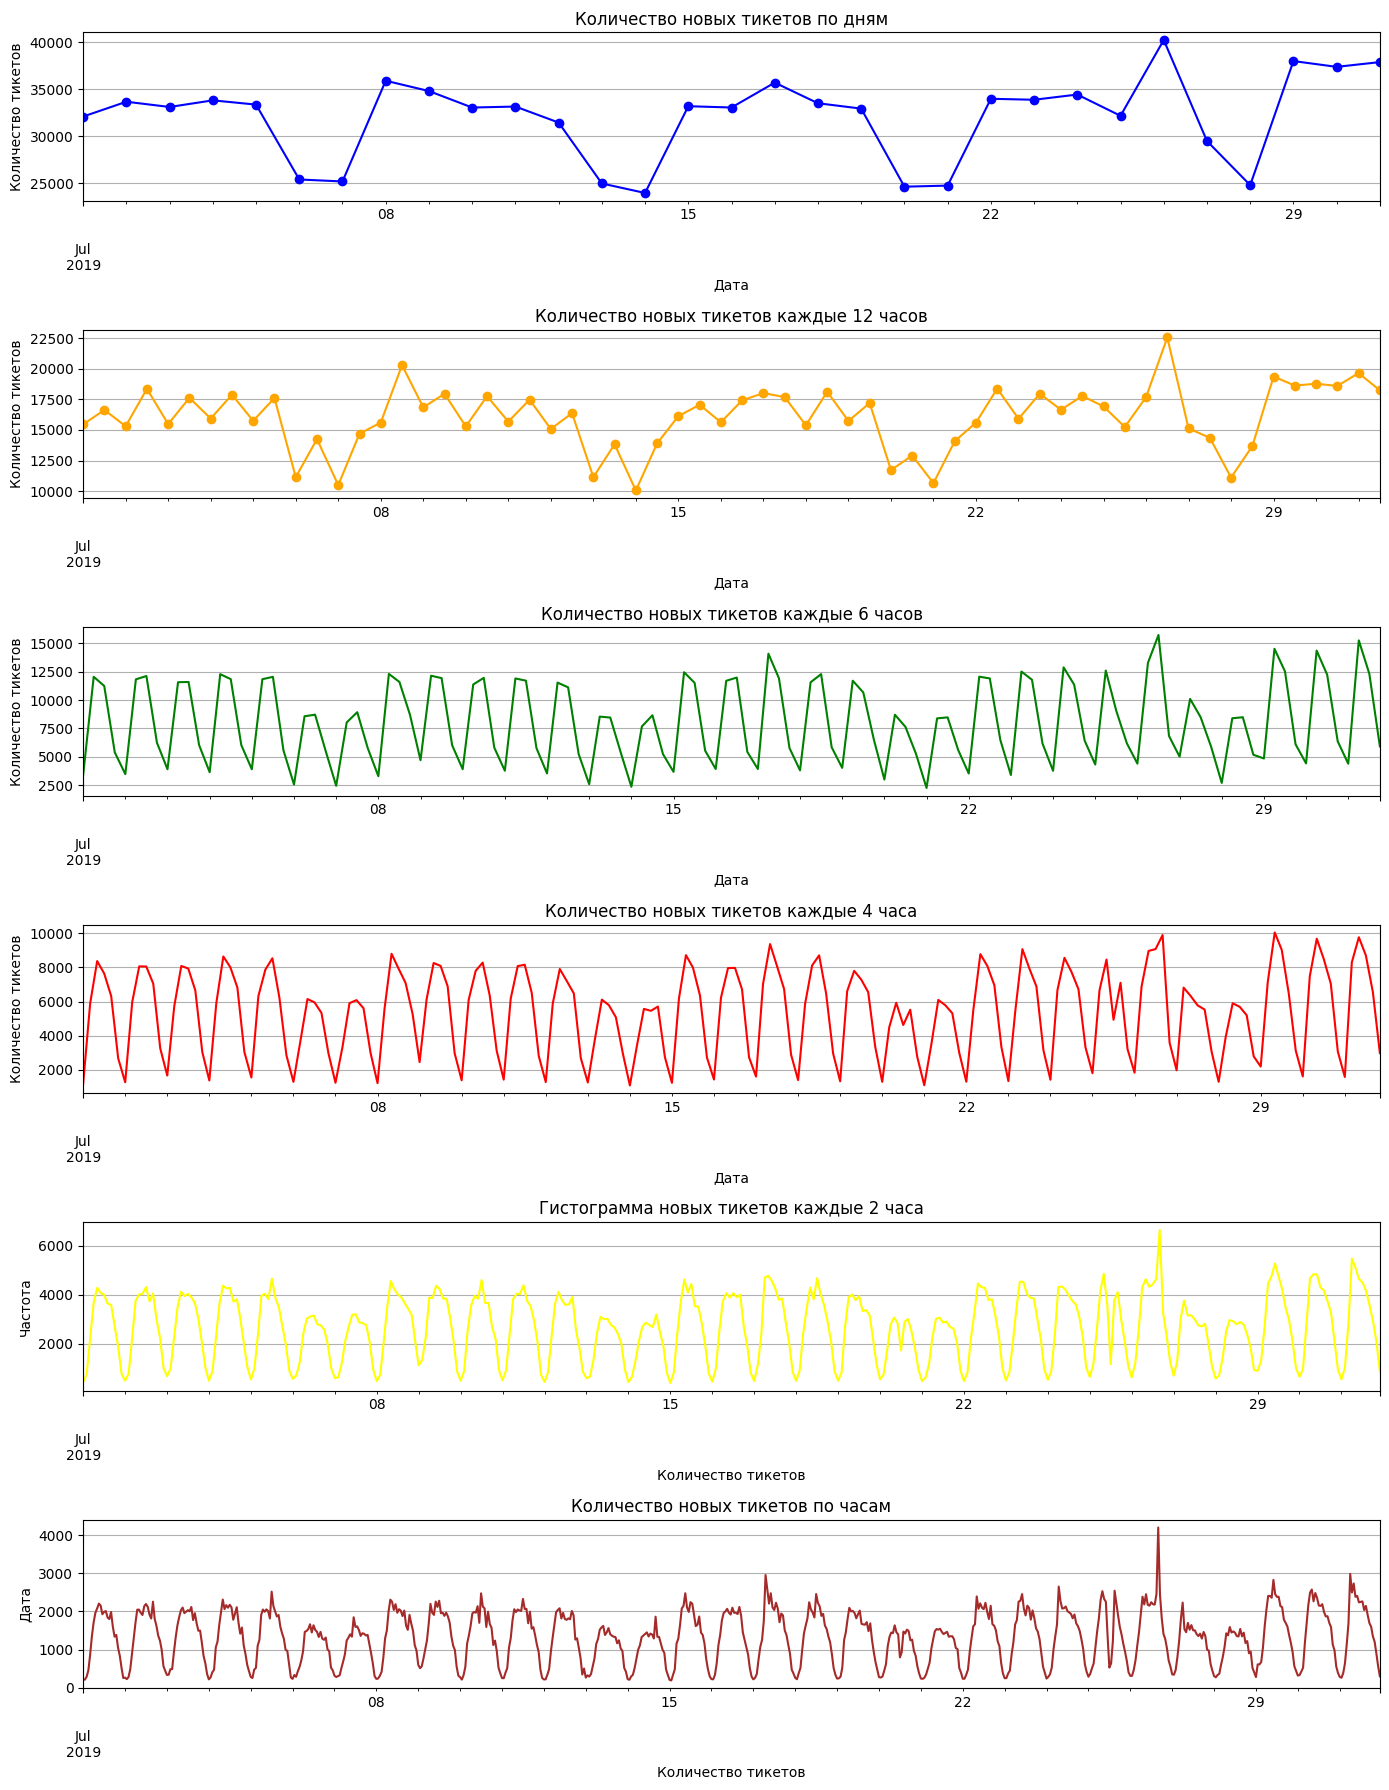

In [ ]:
frequencies = ['D', '12H', '6H', '4H', '2H', 'H']
resampled_data = {}

# Ресэмплирование и сохранение результатов
for freq in frequencies:
    resampled_data[freq] = df.resample(freq, on='date')['new_t'].count()

# Создаем отдельные графики для каждой частоты
plt.figure(figsize=(14, 18))

# Ресэмплирование по дням
plt.subplot(6, 1, 1)
resampled_data['D'].plot(color='blue', marker='o', linestyle='-')
plt.title('Количество новых тикетов по дням')
plt.xlabel('Дата')
plt.ylabel('Количество тикетов')
plt.grid(True)

# Ресэмплирование по 12 часам
plt.subplot(6, 1, 2)
resampled_data['12H'].plot( color='orange', marker='o', linestyle='-')
plt.title('Количество новых тикетов каждые 12 часов')
plt.xlabel('Дата')
plt.ylabel('Количество тикетов')
plt.grid(True)

# Ресэмплирование по 6 часам
plt.subplot(6, 1, 3)
resampled_data['6H'].plot( color='green')
plt.title('Количество новых тикетов каждые 6 часов')
plt.xlabel('Дата')
plt.ylabel('Количество тикетов')
plt.grid(True)

# Ресэмплирование по 4 часам
plt.subplot(6, 1, 4)
resampled_data['4H'].plot( color='red')
plt.title('Количество новых тикетов каждые 4 часа')
plt.xlabel('Дата')
plt.ylabel('Количество тикетов')
plt.grid(True)

# Ресэмплирование по 2 часам
plt.subplot(6, 1, 5)
resampled_data['2H'].plot( color='yellow')
plt.title('Гистограмма новых тикетов каждые 2 часа')
plt.xlabel('Количество тикетов')
plt.ylabel('Частота')
plt.grid(True)

# Ресэмплирование по часам
plt.subplot(6, 1, 6)
resampled_data['H'].plot(color='brown')
plt.title('Количество новых тикетов по часам')
plt.xlabel('Количество тикетов')
plt.ylabel('Дата')
plt.grid(True)

# Настройки для улучшения отображения
plt.tight_layout()
plt.show()